In [1]:
import torch
from torch.utils.data import Dataset
import h5py
import numpy as np
import os.path as osp
import pickle

import six

/home/purewhite/anaconda3/envs/default/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


---
# Dataloader Probe

In [1]:
from dataset.dataset import SketchDataset

trainSet = SketchDataset(
    mode='valid',
    data_seq_dir='/home/purewhite/workspace/cs420/project/data/dataset_raw',
    data_img_dir='/home/purewhite/workspace/cs420/project/data/dataset_processed_28',
    categories=['bear', 'cat', 'crocodile', 'elephant'],
    paddingLength=150,
    random_scale_factor=0.2,
    augment_stroke_prob=0.05,
    img_scale_ratio=0.5,
    img_rotate_angle=15,
    img_translate_dist=5
)

/home/purewhite/anaconda3/envs/default/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[*] Loaded 2500 valid sequences from bear.npz
[*] Loaded 2500 valid images from bear.npz
[*] Loaded 2500 valid sequences from cat.npz
[*] Loaded 2500 valid images from cat.npz
[*] Loaded 2500 valid sequences from crocodile.npz
[*] Loaded 2500 valid images from crocodile.npz
[*] Loaded 2500 valid sequences from elephant.npz
[*] Loaded 2500 valid images from elephant.npz


In [2]:
sample = trainSet[0]

In [3]:
print(len(sample))
strokes_5d, img, label = sample
print(strokes_5d.shape, img.shape, label)

3
(150, 5) (28, 28) 0


In [4]:
from torch.utils.data import DataLoader

trainLoader = DataLoader(trainSet, batch_size=4, shuffle=True, pin_memory=True)

In [7]:
from tqdm import tqdm

loop = tqdm(trainLoader)
for i, batch in enumerate(loop):
    strokes, imgs, labels = batch
    print(strokes.shape, imgs.shape, labels)
    if (i > 5):
        break

  0%|          | 6/2500 [00:00<00:13, 190.89it/s]

torch.Size([4, 150, 5]) torch.Size([4, 28, 28]) tensor([0, 3, 2, 3])
torch.Size([4, 150, 5]) torch.Size([4, 28, 28]) tensor([3, 0, 2, 2])
torch.Size([4, 150, 5]) torch.Size([4, 28, 28]) tensor([1, 1, 0, 1])
torch.Size([4, 150, 5]) torch.Size([4, 28, 28]) tensor([3, 1, 1, 2])
torch.Size([4, 150, 5]) torch.Size([4, 28, 28]) tensor([0, 0, 3, 2])
torch.Size([4, 150, 5]) torch.Size([4, 28, 28]) tensor([0, 0, 1, 1])
torch.Size([4, 150, 5]) torch.Size([4, 28, 28]) tensor([0, 1, 3, 0])


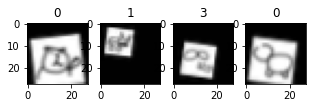

In [9]:
from matplotlib import pyplot as plt

plt.figure(figsize=(5, 20))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(imgs[i].cpu().numpy(), cmap='binary_r')
    plt.title(f'{labels[i]}')

---
# Feat Probe

In [4]:
data_seq = np.load('/home/purewhite/workspace/cs420/project/data/dataset_raw/bear.npz', mmap_mode='r', encoding='latin1', allow_pickle=True)
print(list(data_seq.keys()))
for k, v in data_seq.items():
    print(v.shape, [v[i].shape for i in range(3)])

['test', 'train', 'valid']
(2500,) [(86, 3), (61, 3), (111, 3)]
(70000,) [(47, 3), (65, 3), (114, 3)]
(2500,) [(42, 3), (74, 3), (92, 3)]


In [5]:
print(type(data_seq))

<class 'numpy.lib.npyio.NpzFile'>


In [6]:
print(data_seq['train'][0])

[[ 43   0   0]
 [  8   6   1]
 [  6   1   0]
 [  1 -10   0]
 [ 11 -11   0]
 [  7  -3   0]
 [ 13   0   0]
 [  6   3   0]
 [  7  22   0]
 [ -3   6   0]
 [-27  20   1]
 [-72 -37   0]
 [ -1  -7   0]
 [-15  -2   0]
 [-13   5   0]
 [ -2   6   0]
 [  7  26   0]
 [ 12   9   1]
 [ 41  11   0]
 [ -6   1   0]
 [ -5   7   0]
 [ -2  13   0]
 [  3   7   0]
 [  7   5   0]
 [ 11   1   0]
 [  5  -5   0]
 [ -1 -25   0]
 [-11  -3   0]
 [ -9   3   0]
 [-12  10   1]
 [-14 -19   0]
 [ -6  30   0]
 [  0  21   0]
 [  3   6   0]
 [ 20  16   0]
 [  8   3   0]
 [ 37   0   0]
 [  8  -2   0]
 [ 11 -14   0]
 [  6 -25   0]
 [ -5 -33   0]
 [ -3  -6   0]
 [ -7  -4   1]
 [-51   5   0]
 [  0   0   1]
 [ -4  -6   0]
 [  2   5   1]]


In [7]:
data_img = np.load('/home/purewhite/workspace/cs420/project/data/dataset_processed_28/bear.npz', mmap_mode='r', encoding='latin1', allow_pickle=True)
print(list(data_img.keys()))
for k, v in data_img.items():
    print(v.shape)

['train', 'valid', 'test']
(70000, 28, 28)
(2500, 28, 28)
(2500, 28, 28)


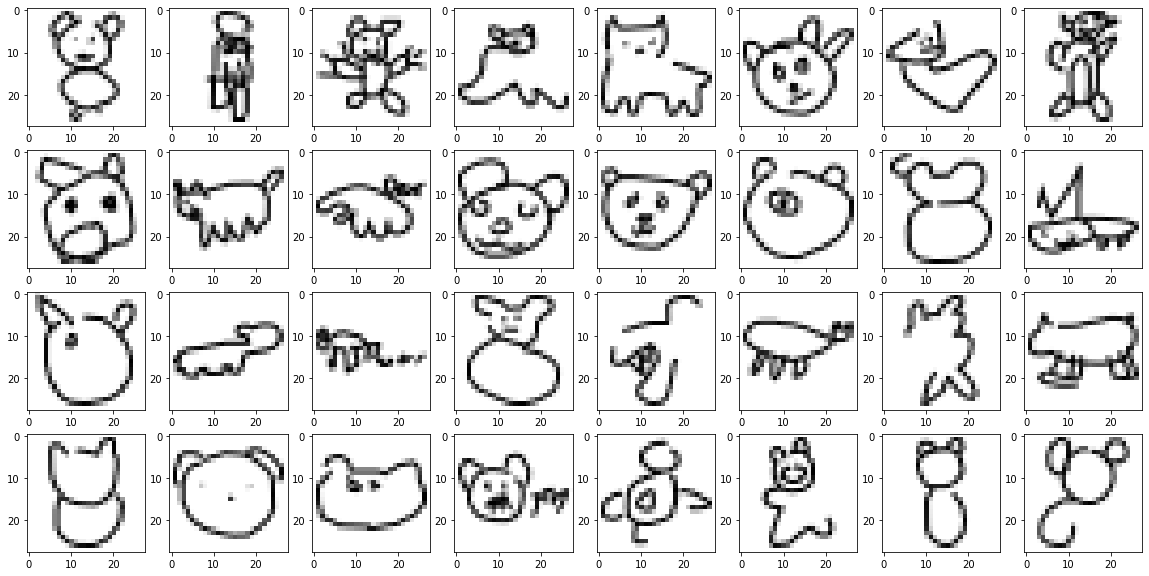

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))

for i in range(32):
    plt.subplot(4, 8, i+1)
    plt.imshow(data_img['test'][i], cmap='binary_r')

plt.show()

In [26]:
import os
path_root = '/home/purewhite/workspace/cs420/project/data/dataset_processed_28/'

for file in os.listdir(path_root):
    tmp = file.replace('_', '.').split('.')
    os.rename(path_root+file, path_root+tmp[0]+'.'+tmp[-1])

In [29]:
import os
path_root = '/home/purewhite/workspace/cs420/project/data/dataset_raw/'

for file in os.listdir(path_root):
    tmp = file.replace('_', '.').split('.')
    # print(tmp)
    os.rename(path_root+file, path_root+tmp[-2]+'.'+tmp[-1])